In [1]:
import os
os.chdir(os.path.join(os.getcwd(),os.pardir))

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# setup langsmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "flipkart-scraping"

In [3]:
# setup async loop for notebooks
import nest_asyncio
nest_asyncio.apply()

In [4]:
from typing import List, Optional, TypedDict
from langchain_core.messages import BaseMessage, SystemMessage
from playwright.async_api import Page

class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str

class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]

class AgentState(TypedDict):
    page: Page  # playwright page object
    input: str  # input from the user
    img: str  # b64 encoded screenshot
    bboxes: List[BBox]  # the center coordinates of the bounding boxes of the detected elements from the screenshot annotated by the agent
    prediction: Prediction  # the prediction made by the agent
    scratchpad: List[BaseMessage] # a system message (or messages) containing the intermediate steps
    observation: str  # the most recent observation made by the agent

In [5]:
import asyncio
import platform


async def click(state: AgentState):
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number, the arguments are not correct: {click_args}"
    bbox_id = int(click_args[0])
    try:
        bbox = state["bboxes"][bbox_id]
    except:
        return f"Error: No bbox for ID: {bbox_id}"
    x, y = bbox["x"], bbox["y"]
    res = await page.mouse.click(x, y)
    return f"Clicked {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["prediction"]["args"]
    if type_args is None or len(type_args) != 2:
        return (
            f"Failed to type in element from bounding box labeled as number. Arguments are not correct: {type_args}"
        )
    bbox_id = int(type_args[0])
    bbox = state["bboxes"][bbox_id]
    x, y = bbox["x"], bbox["y"]
    text_content = type_args[1]
    await page.mouse.click(x, y)
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    await page.keyboard.press("Enter")
    return f"Typed {text_content} and submitted"


async def scroll(state: AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return "Failed to scroll due to incorrect arguments: {scroll_args}"

    target, direction = scroll_args

    if target.upper() == "WINDOW":
        scroll_amount = 500
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x, y = bbox["x"], bbox["y"]
        scroll_direction = (
            -scroll_amount if direction.lower() == "up" else scroll_amount
        )
        await page.mouse.move(x, y)
        await page.mouse.wheel(0, scroll_direction)

    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else 'element'}"


async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s."


async def go_back(state: AgentState):
    page = state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."


async def to_google(state: AgentState):
    page = state["page"]
    await page.goto("https://www.google.com/")
    return "Navigated to google.com."

In [6]:
import asyncio
import base64
from langchain_core.runnables import chain as chain_decorator

with open("mark_page.js") as f:
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range(10):
        try:
            bboxes = await page.evaluate("markPage()")
            break
        except:
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    await page.evaluate("unmarkPage()")
    return {
        "img": base64.b64encode(screenshot).decode(),
        "bboxes": bboxes,
    }

In [7]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI


async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}


def format_descriptions(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel","")
        if not text.strip():
            text = bbox["text"]
        el_type = bbox.get("type")
        labels.append(f'{i} (<{el_type}/>): "{text}"')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bbox_descriptions": bbox_descriptions}


def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "args": action_input}


# Will need a later version of langchain to pull
# this image prompt template
prompt = hub.pull("wfh/web-voyager")

In [12]:
llm = ChatOpenAI(model="gpt-4o", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction=format_descriptions | prompt | llm | StrOutputParser() | parse
)

In [13]:
import re

def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['observation']}"

    return {**state, "scratchpad": [SystemMessage(content=txt)]}

In [14]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)


graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "GoBack": go_back,
    "Google": to_google,
}


for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]
    if action == "ANSWER":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

graph = graph_builder.compile()

In [18]:
import playwright
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

1. Click: ['19']
2. Click: ['13']
3. Type: ['3', 'Content']
4. Click: ['19']


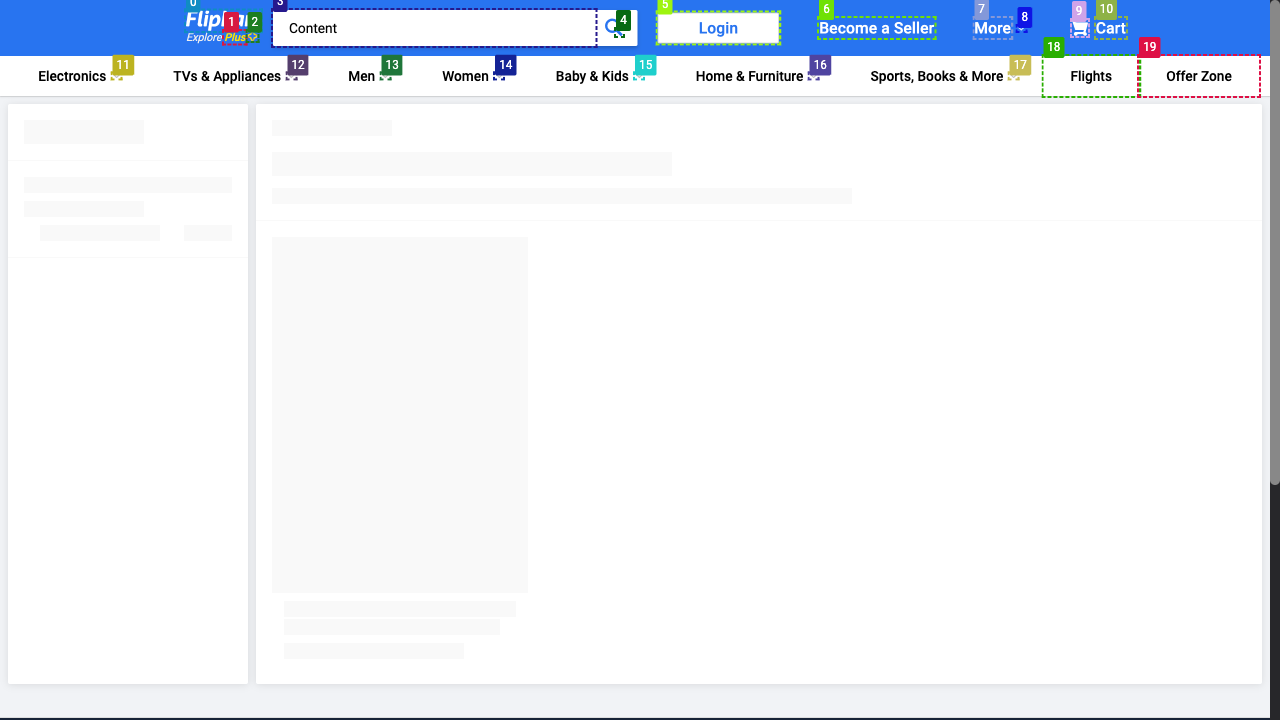

CancelledError: 

In [23]:
res = await call_agent("Navigate to flipkart and strictly stop.", page)
print(f"Final response: {res}")

In [28]:
browser.close()

<coroutine object Browser.close at 0x16bd7b140>